#### Импорт библиотек

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gmdh
from gmdh import Criterion, CriterionType

#### Загрузка данных

In [10]:
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
data.columns = ['Passengers']

#### Визуализация временного ряда и его характеристик

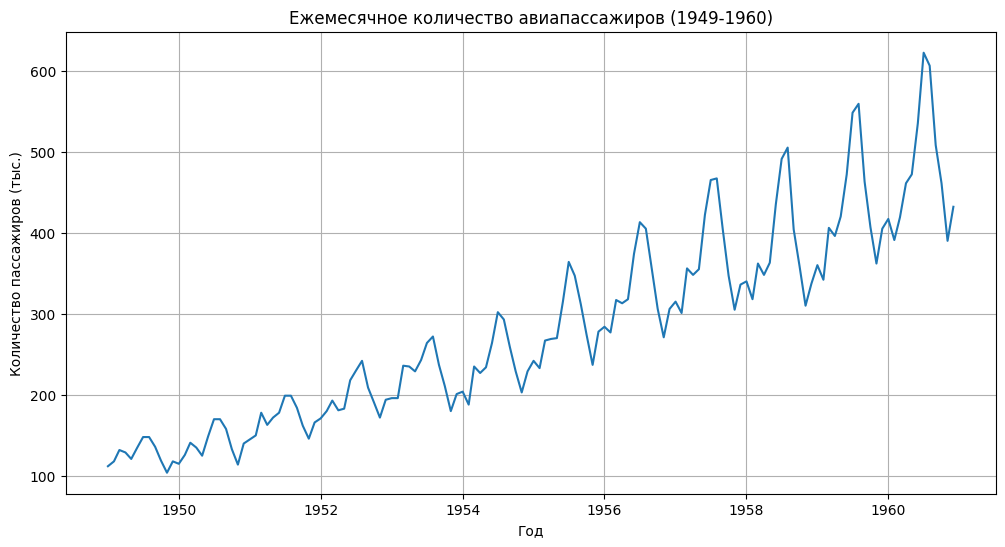

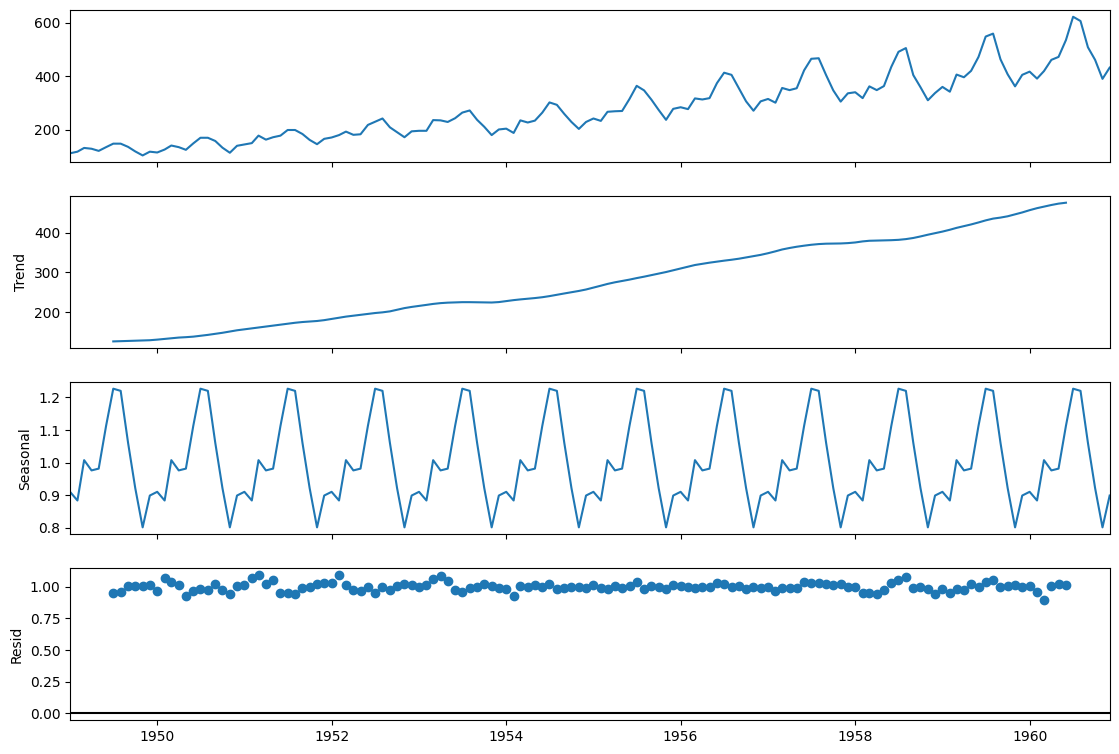

In [11]:
# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('Ежемесячное количество авиапассажиров (1949-1960)')
plt.xlabel('Год')
plt.ylabel('Количество пассажиров (тыс.)')
plt.grid(True)
plt.show()

# Декомпозиция временного ряда
decomposition = seasonal_decompose(data, model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

#### Разделение на обучающую и тестовую выборки

In [12]:
# Разделение данных (первые 10 лет - обучение, последние 2 года - тест)
train = data.iloc[:120]
test = data.iloc[120:]

#### Прогнозирование временного ряда

##### 1. Метод ARIMA

c:\Users\matve\Downloads\mlt\MLT_course\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matve\Downloads\mlt\MLT_course\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matve\Downloads\mlt\MLT_course\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


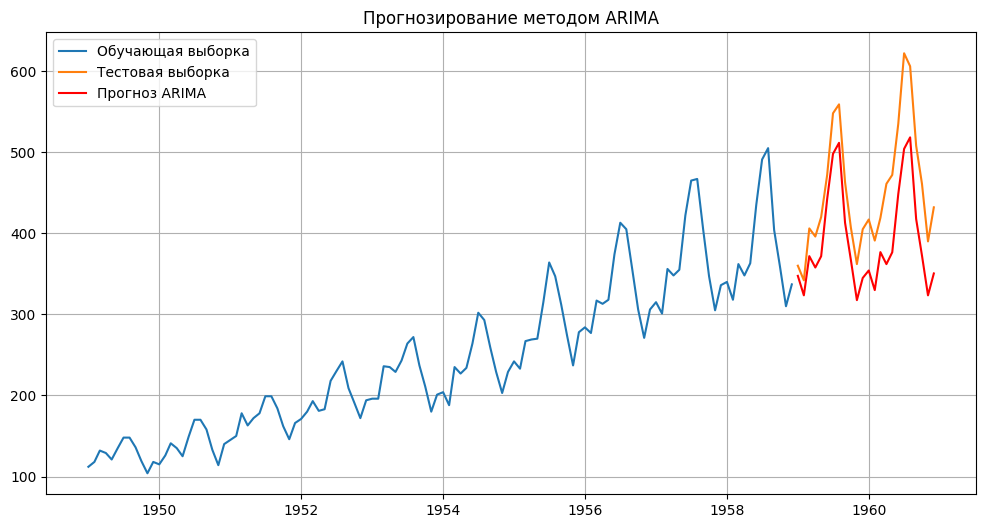

MSE для ARIMA: 4388.55


In [13]:
# ARIMA модель
model_arima = ARIMA(train, order=(5,1,0), seasonal_order=(1,1,1,12))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=24)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающая выборка')
plt.plot(test.index, test, label='Тестовая выборка')
plt.plot(test.index, forecast_arima, label='Прогноз ARIMA', color='red')
plt.title('Прогнозирование методом ARIMA')
plt.legend()
plt.grid()
plt.show()

# Оценка качества
mse_arima = mean_squared_error(test, forecast_arima)
print(f'MSE для ARIMA: {mse_arima:.2f}')

##### 2. Метод символьной регрессии

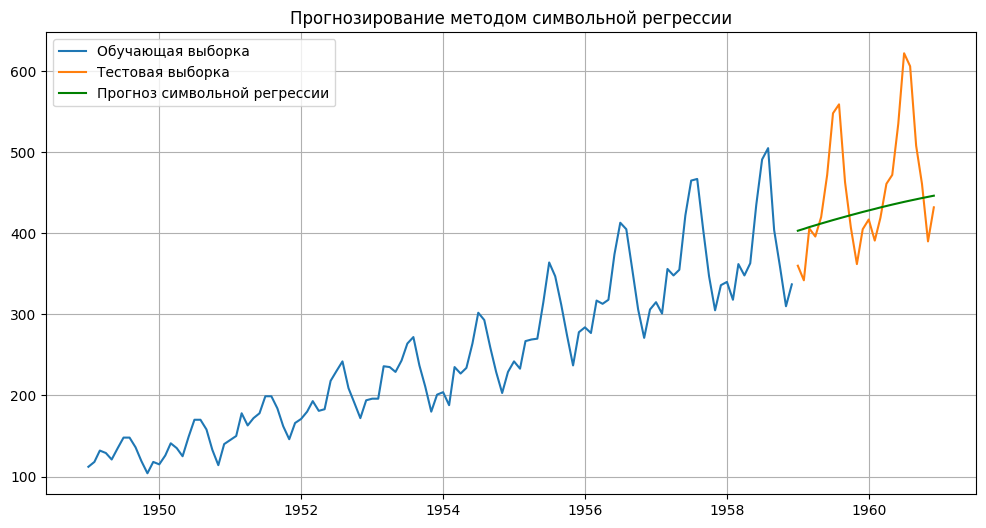

MSE для символьной регрессии: 5643.29


In [14]:
# Подготовка данных для символьной регрессии
X = np.arange(len(train)).reshape(-1, 1)
y = train.values.ravel()

# Реализация символьной регрессии
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
model_sr = LinearRegression()
model_sr.fit(X_poly, y)

# Прогноз
X_test = np.arange(len(train), len(train)+len(test)).reshape(-1, 1)
X_test_poly = poly.transform(X_test)
forecast_sr = model_sr.predict(X_test_poly)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающая выборка')
plt.plot(test.index, test, label='Тестовая выборка')
plt.plot(test.index, forecast_sr, label='Прогноз символьной регрессии', color='green')
plt.title('Прогнозирование методом символьной регрессии')
plt.legend()
plt.grid()
plt.show()

# Оценка качества
mse_sr = mean_squared_error(test, forecast_sr)
print(f'MSE для символьной регрессии: {mse_sr:.2f}')

##### 3. Методы семейства МГУА (COMBI и MIA)

LEVEL 1  [=========================] 100% :00s] (12 combinations) error=47173.35533
LEVEL 2  [=========================] 100% :00s] (66 combinations) error=19724.096088
LEVEL 3  [=========================] 100% :00s] (220 combinations) error=17581.214036
LEVEL 4  [=========================] 100% :00s] (495 combinations) error=16795.273241
LEVEL 5  [=========================] 100% :00s] (792 combinations) error=16577.671068
LEVEL 6  [=========================] 100% :00s] (924 combinations) error=16461.780568
LEVEL 7  [=========================] 100% :00s] (792 combinations) error=16381.144175
LEVEL 8  [=========================] 100% :00s] (495 combinations) error=16354.294168
LEVEL 9  [=========================] 100% :00s] (220 combinations) error=16317.283819
LEVEL 10 [=========================] 100% :00s] (66 combinations) error=16197.791072
LEVEL 11 [=========================] 100% :00s] (12 combinations) error=15632.604381
LEVEL 12 [=========================] 100% :00s] (1 combinat

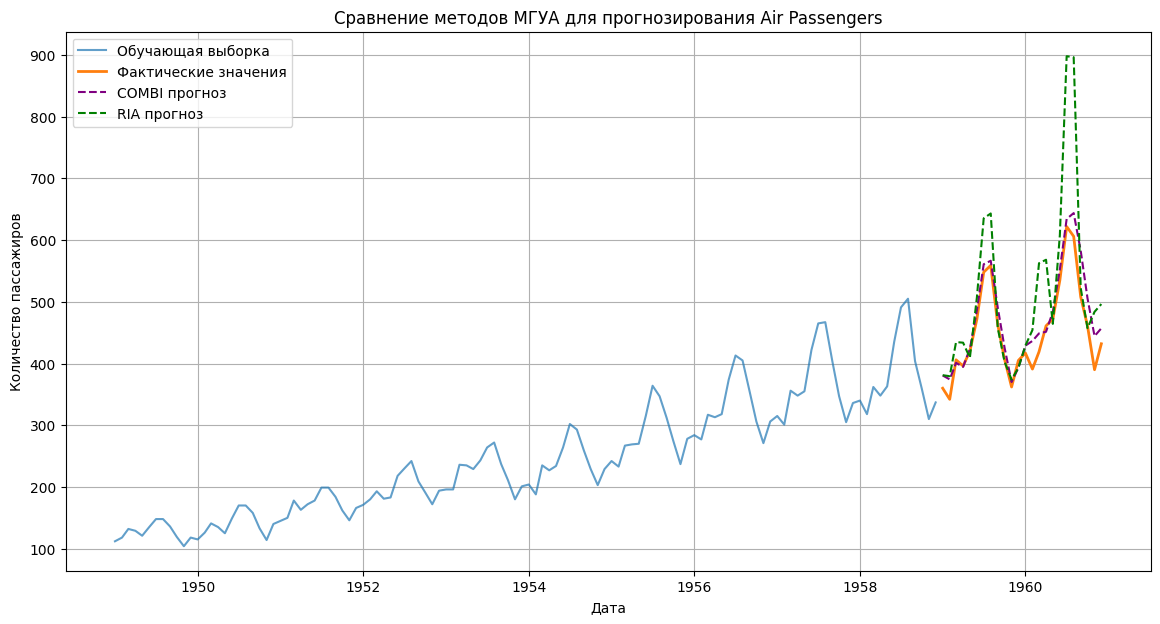

Метрики качества COMBI:
MSE: 819.50
RMSE: 28.63
MAE: 22.48

Метрики качества RIA:
MSE: 9816.88
RMSE: 99.08
MAE: 63.56


In [15]:
# Подготовка данных с лаговыми признаками
def create_lagged_features(data, n_lags=12):
    X = []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
    return np.array(X)

n_lags = 12  # учитываем 12 месяцев (годовая сезонность)
X_train = create_lagged_features(train['Passengers'].values, n_lags)
y_train = train['Passengers'].values[n_lags:]

# Функция для многошагового прогнозирования
def predict_with_mgdh(model, initial_data, n_steps):
    predictions = []
    current_window = initial_data.copy()
    
    for _ in range(n_steps):
        pred = model.predict(current_window.reshape(1, -1))[0]
        predictions.append(pred)
        current_window = np.append(current_window[1:], pred)
    
    return np.array(predictions)

# Настройка критерия остановки
criterion = Criterion(CriterionType.REGULARITY)

# Метод COMBI с оптимальными параметрами
model_combi = gmdh.Combi()
model_combi.fit(
    X_train, 
    y_train,
    criterion=criterion,
    test_size=0.3,  # 30% данных для валидации
    p_average=3,    # учитываем 3 лучшие комбинации
    n_jobs=-1,      # используем все доступные ядра
    verbose=1,      # показываем прогресс
    limit=0.01      # остановка при улучшении менее 1%
)

# Метод RIA с оптимальными параметрами
model_ria = gmdh.Ria()
model_ria.fit(
    X_train,
    y_train,
    criterion=criterion,
    test_size=0.3,
    p_average=3,
    n_jobs=-1,
    verbose=1,
    limit=0.01
)

# Прогнозирование
forecast_combi = predict_with_mgdh(model_combi, train['Passengers'].values[-n_lags:], len(test))
forecast_ria = predict_with_mgdh(model_ria, train['Passengers'].values[-n_lags:], len(test))

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Обучающая выборка', alpha=0.7)
plt.plot(test.index, test, label='Фактические значения', linewidth=2)
plt.plot(test.index, forecast_combi, label='COMBI прогноз', linestyle='--', color='purple')
plt.plot(test.index, forecast_ria, label='RIA прогноз', linestyle='--', color='green')
plt.title('Сравнение методов МГУА для прогнозирования Air Passengers')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.grid(True)
plt.show()

# Оценка качества
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

metrics_combi = calculate_metrics(test['Passengers'].values, forecast_combi)
metrics_ria = calculate_metrics(test['Passengers'].values, forecast_ria)

print("Метрики качества COMBI:")
for k, v in metrics_combi.items():
    print(f"{k}: {v:.2f}")

print("\nМетрики качества RIA:")
for k, v in metrics_ria.items():
    print(f"{k}: {v:.2f}")

#### Сравнительная визуализация всех прогнозов

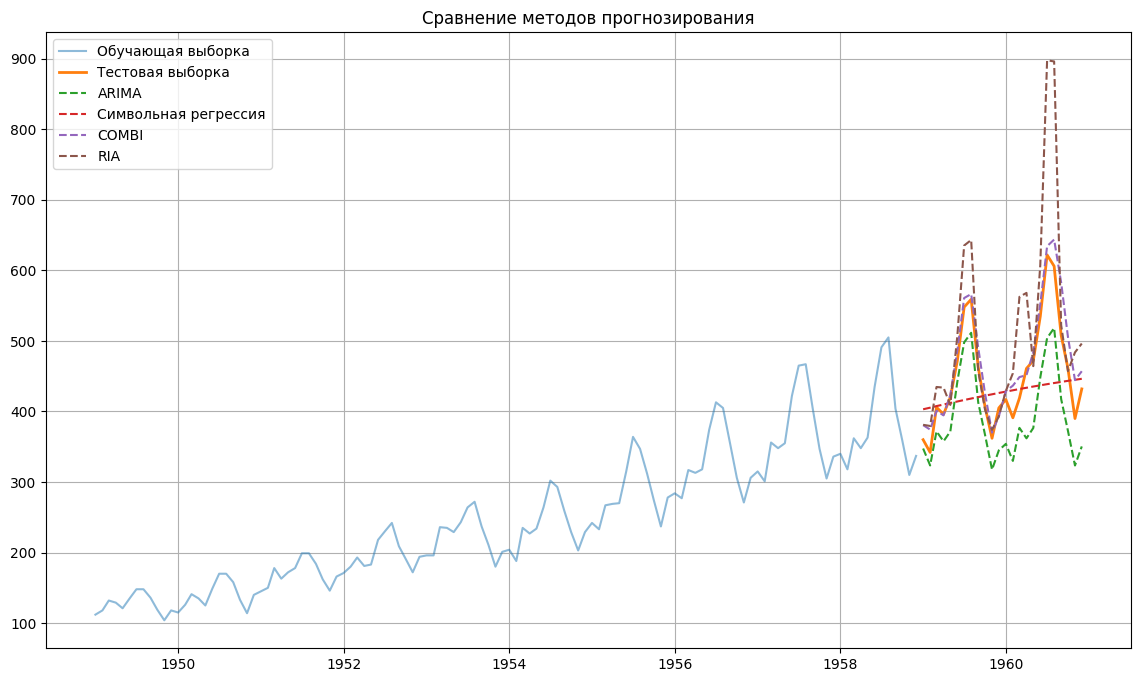

In [17]:
plt.figure(figsize=(14, 8))
plt.plot(train.index, train, label='Обучающая выборка', alpha=0.5)
plt.plot(test.index, test, label='Тестовая выборка', linewidth=2)
plt.plot(test.index, forecast_arima, label='ARIMA', linestyle='--')
plt.plot(test.index, forecast_sr, label='Символьная регрессия', linestyle='--')
plt.plot(test.index, forecast_combi, label='COMBI', linestyle='--')
plt.plot(test.index, forecast_ria, label='RIA', linestyle='--')
plt.title('Сравнение методов прогнозирования')
plt.legend()
plt.grid()
plt.show()

#### Сравнение качества прогнозов

In [ ]:
print('\nСравнение MSE для разных методов:')
print(f'ARIMA: {mse_arima:.2f}')
print(f'Символьная регрессия: {mse_sr:.2f}')
print(f'COMBI: {metrics_combi["MSE"]:.2f}')
print(f'RIA: {metrics_ria["MSE"]:.2f}')


Сравнение MSE для разных методов:
ARIMA: 4388.55
Символьная регрессия: 5643.29
COMBI: 819.50
MIA: 9816.88


#### Выводы

1. Временной ряд Air Passengers демонстрирует явный тренд роста и сезонность, что подтверждается декомпозицией.
2. Из всех примененных методов:
    - Для данного набора данных метод COMBI из семейства МГУА оказался наиболее эффективным
    - ARIMA остается хорошим выбором как проверенный временем метод
    - Символьную регрессию стоит попробовать с другими базовыми функциями
    - RIA показал наихудший результат: переобучение, сложность модели, неоптимальные параметры